In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
color = sns.color_palette('Set3')

In [44]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization

from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
#from sklearn.utils.class_weight import compute_class_weight
#from imblearn.over_sampling import SMOTENC

Using TensorFlow backend.


In [2]:
users = pd.read_csv('users_copy.csv')
sessions = pd.read_csv('sessions_copy.csv')
purchase = pd.read_csv('iapscopy.csv')
spend = pd.read_csv('spendevents_copy.csv')

users['install_date'] = pd.to_datetime(users['install_date'])
sessions['date'] = pd.to_datetime(sessions['date'])
purchase['date'] = pd.to_datetime(purchase['date'])
spend['date'] = pd.to_datetime(spend['date'])

sessions['ts'] = pd.to_datetime(sessions['ts'], format='%m/%d/%y %H:%M')
purchase['ts'] = pd.to_datetime(purchase['ts'], format='%m/%d/%y %H:%M')
spend['ts'] = pd.to_datetime(spend['ts'], format='%m/%d/%y %H:%M')


In [19]:
users.head()

,udid,install_date,lang,country,hw_ver,os_ver
0,88258a36ad1447c4b407bb782c9f7f39,2016-03-01,th,TH,"iPhone6,2",9.2.1
1,8f3d900d5d624e95afc95a1e5ffe49fb,2016-03-01,id,ID,"iPhone6,1",8
2,90167c9cf1b9406fb81401da39b800b9,2016-03-01,en,US,"iPad5,1",9.2.1
3,479dbe15a9b5421a903361931d5d579c,2016-03-01,en,GB,"iPhone8,2",9.2.1
4,c2c421a8a7054a90b57bf67af45f9722,2016-03-01,pt,AO,"iPhone7,2",9.2.1


In [20]:
sessions.head()

,udid,ts,date,session_num,last_session_termination_type
0,f19efdcec2f0414e9507c19da467af20,2016-03-01 00:13:00,2016-03-01,1,NaN
1,f19efdcec2f0414e9507c19da467af20,2016-03-01 00:27:00,2016-03-01,2,NaN
2,f19efdcec2f0414e9507c19da467af20,2016-03-01 00:29:00,2016-03-01,3,NaN
3,f19efdcec2f0414e9507c19da467af20,2016-03-01 00:34:00,2016-03-01,4,NaN
4,f19efdcec2f0414e9507c19da467af20,2016-03-01 00:50:00,2016-03-01,5,NaN


In [21]:
purchase.head()

,udid,ts,date,prod_name,prod_type,rev
0,a737cacac9b9432180f7106c248dc9dc,2016-03-01 09:35:00,2016-03-01,iap_1_gems_2,gems,140
1,a737cacac9b9432180f7106c248dc9dc,2016-03-01 09:51:00,2016-03-01,iap_1_gems_2,gems,140
2,a737cacac9b9432180f7106c248dc9dc,2016-03-01 09:56:00,2016-03-01,iap_1_gems_2,gems,140
3,a737cacac9b9432180f7106c248dc9dc,2016-03-01 11:11:00,2016-03-01,iap_1_gems_2,gems,140
4,a737cacac9b9432180f7106c248dc9dc,2016-03-01 11:53:00,2016-03-01,iap_1_gems_1,gems,70


In [22]:
spend.head()

,udid,ts,date,story,chapter,spendtype,currency,amount
0,319d57bc3d9445c78fbeda4772ecbc9b,2016-03-01 00:46:00,2016-03-01,Mean_Girls_Version_D,0,earnGemsCounter,gems,-5
1,988291d1f38d4b0e97c2c86fb4d0122f,2016-03-01 03:43:00,2016-03-01,Mean_Girls_Version_D,0,earnGemsCounter,gems,-5
2,1e7a9cbe6fb44ecd93c3b47e64f4c377,2016-03-01 04:19:00,2016-03-01,Mean_Girls_Version_D,0,earnGemsCounter,gems,-5
3,309d0946c01a46e88a9038da40145a9e,2016-03-01 05:29:00,2016-03-01,Demi_Master,0,earnGemsCounter,gems,-5
4,2cddbc83fd464957bdbc71bfa831a61b,2016-03-01 05:32:00,2016-03-01,Mean_Girls_Version_D,0,earnGemsCounter,gems,-5


## EDA

In [3]:
# daily session, purchase, spend
# sessions_daily: user x date, session count, install date, country
sessions_daily = sessions.groupby(['udid','date']).agg({
    'session_num':'count'
}).reset_index()
sessions_daily = pd.merge(sessions_daily, 
                          users[['udid', 'install_date', 'country']], how='left')

# purchase_daily: user x date x prod_type x prod_name, rev
# purchase_daily = purchase.groupby(['udid','date','prod_name','prod_type']).agg({
#     'rev':'sum'
# }).reset_index()

# purchase_daily2: user x date, rev
purchase_daily2 = purchase.groupby(['udid','date']).agg({
    'rev':'sum'
}).reset_index()

# spend_daily
spend_daily = spend.groupby(['udid','date']).agg({
    'amount':'sum'
}).reset_index()

In [4]:
# user features
# user_sessions: user, session count, first session, last session, lifetime
user_sessions = sessions_daily.groupby(['udid']).agg({
    'session_num': 'sum'
}).reset_index()
user_sessions['first_session_date'] = sessions_daily.groupby(['udid'])['date'].min().values
user_sessions['last_session_date'] = sessions_daily.groupby(['udid'])['date'].max().values
user_sessions['lifetime'] = (user_sessions['last_session_date']-user_sessions['first_session_date']).map(lambda x: x.days) + 1

# user_purchase: user, purchase_count, total_amount, first purchase date & amount, last purchase date & amount
user_purchase = purchase_daily2.groupby(['udid']).agg({
    'date': 'count',
    'rev': 'sum'
}).reset_index()
user_purchase.rename(columns={'date':'purchase_count',
                              'rev': 'total_amount'}, inplace=True)

# first purchase date: the day when a user made the first purchase
# first purchase amount: total amount on first purchase date
first_purchase = purchase_daily2.sort_values(by=['udid', 'date'])
first_purchase.drop_duplicates(subset=['udid'], keep='first', inplace=True)
first_purchase.rename(columns={'date':'first_purchase_date',
                              'rev': 'first_purchase_amount'}, inplace=True)
# last_purchase = purchase_daily2.sort_values(by=['udid', 'date'])
# last_purchase.drop_duplicates(subset=['udid'], keep='last', inplace=True)
# last_purchase.rename(columns={'date':'last_purchase_date',
#                               'rev': 'last_purchase_amount'}, inplace=True)
user_purchase = pd.merge(user_purchase, first_purchase, how='left')
# user_purchase = pd.merge(user_purchase, last_purchase, how='left')

users = pd.merge(users, user_purchase, how='left')
users = pd.merge(users, user_sessions, how='left')
users['total_amount'] = users['total_amount'].fillna(0)
users['purchase_count'] = users['purchase_count'].fillna(0)
users['session_num'] = users['session_num'].fillna(0)
# ssv: single-session visitor, users who has <= 1 session
# users['ssv'] = np.where(users['session_num']<=1, 1, 0)
# users['converted'] = np.where(users['total_amount']>0, 1, 0)

In [17]:
users['lifetime'].describe()

count    22544.000000
mean        15.317158
std         19.375423
min          1.000000
25%          1.000000
50%          4.000000
75%         25.000000
max         61.000000
Name: lifetime, dtype: float64

Text(0.5, 1.0, 'User Lifetime')

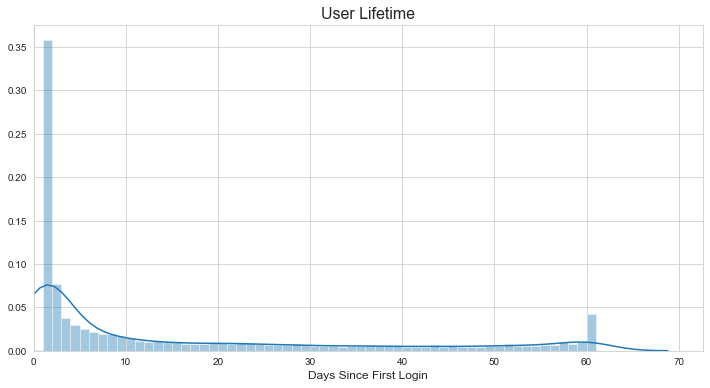

In [20]:
# user lifetime, LTV
f, ax= plt.subplots(figsize=(12,6))
ax = sns.distplot(users['lifetime'].fillna(0), bins=int(users['lifetime'].max()))
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_xlim(0,)
ax.set_title('User Lifetime', fontsize=16)


Text(0.5, 1.0, 'User Lifetime Value')

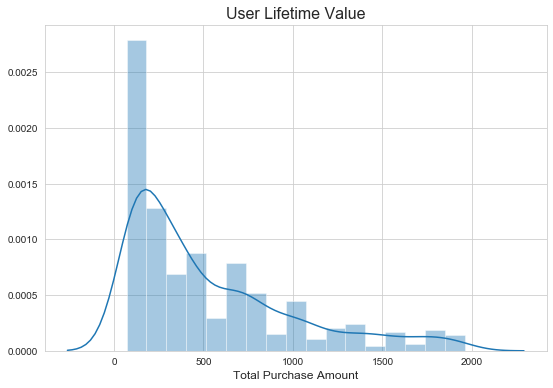

In [171]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.distplot(users[(users['total_amount']>0)&(users['total_amount']<=2000)]['total_amount'])
ax.set_xlabel('Total Purchase Amount', fontsize=12)
ax.set_title('User Lifetime Value', fontsize=16)

Text(0.5, 1.0, 'User Lifetime VS Purchase Value')

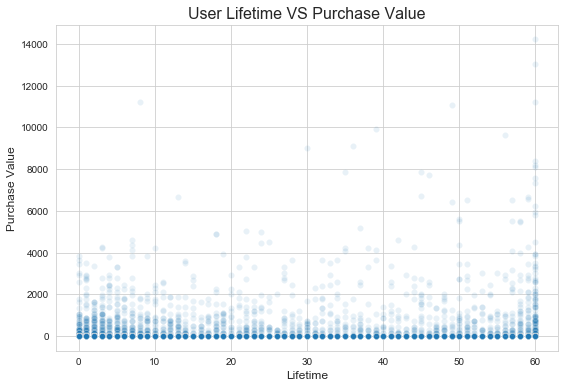

In [38]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.scatterplot(users['lifetime'].fillna(0), 
                     users['total_amount'].fillna(0), 
                     alpha=0.1)
ax.set_xlabel('Lifetime', fontsize=12)
ax.set_ylabel('Purchase Value', fontsize=12)
ax.set_title('User Lifetime VS Purchase Value', fontsize=16)

In [69]:
# daily active users, paid users
tmp = ud.groupby('T').agg({
    'udid': 'count',
    'rev': 'count'
}).reset_index()

In [70]:
tmp['paid_user_rate'] = tmp['rev']/tmp['udid']

In [74]:
tmp['user_count_lag1'] = tmp['udid'].shift(periods=1)

In [76]:
tmp['churn_rate'] = (tmp['user_count_lag1'] - tmp['udid'])/tmp['user_count_lag1']

Text(0.5, 1.0, 'Daily Churn Rate')

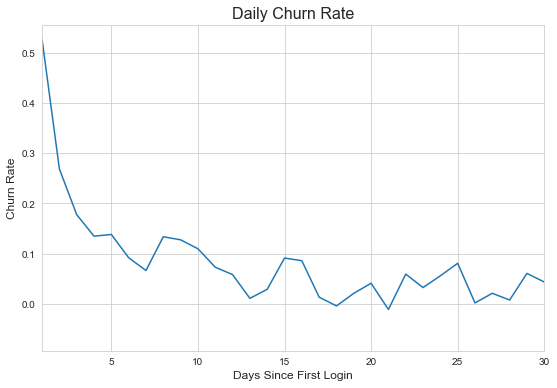

In [78]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], tmp['churn_rate'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Churn Rate', fontsize=12)
ax.set_xlim(1, 30)
ax.set_title('Daily Churn Rate', fontsize=16)

Text(0.5, 1.0, 'Daily Active Users')

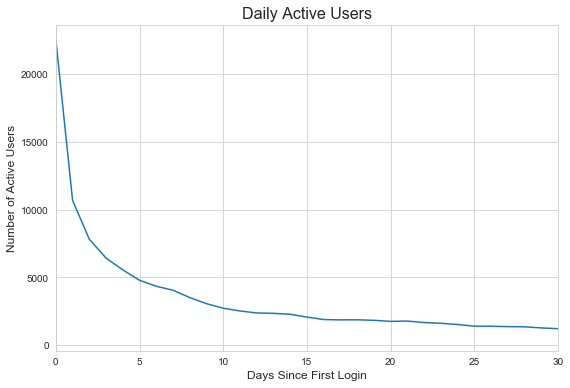

In [35]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], tmp['udid'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Number of Active Users', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Daily Active Users', fontsize=16)

Text(0.5, 1.0, 'Daily Paid Users')

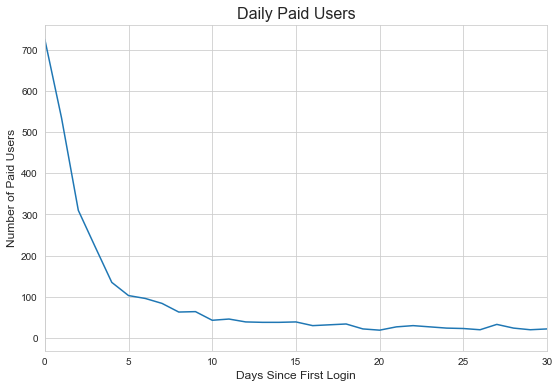

In [36]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], tmp['rev'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Number of Paid Users', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Daily Paid Users', fontsize=16)

Text(0.5, 1.0, 'Daily Paid User Rate')

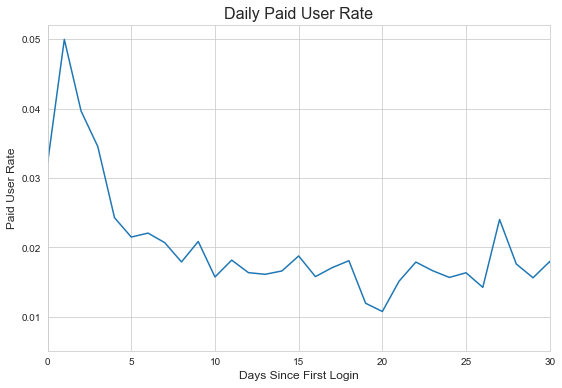

In [73]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], tmp['paid_user_rate'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Paid User Rate', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Daily Paid User Rate', fontsize=16)

In [6]:
tmp = ud.groupby('T').agg({
    'rev': 'sum',
    'amount': 'sum'
}).reset_index()


In [7]:
tmp['rev_cumsum'] = tmp['rev'].cumsum()

In [8]:
total_rev = tmp['rev'].sum()
tmp['rev_cumpct'] = tmp['rev_cumsum']/total_rev

In [183]:
tmp['rev_cumpct'][:30]

0     0.279237
1     0.453629
2     0.551024
3     0.610093
4     0.643191
5     0.667128
6     0.690870
7     0.709187
8     0.731525
9     0.744171
10    0.755316
11    0.766993
12    0.777943
13    0.787489
14    0.796210
15    0.803479
16    0.810164
17    0.818110
18    0.827944
19    0.834583
20    0.839429
21    0.845340
22    0.853820
23    0.859636
24    0.866564
25    0.872523
26    0.876788
27    0.888271
28    0.897477
29    0.901596
Name: rev_cumpct, dtype: float64

Text(0.5, 1.0, 'Cumulative Revenue')

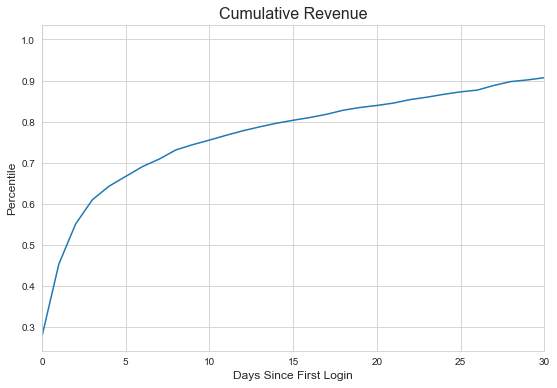

In [186]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], tmp['rev_cumpct'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Percentile', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Cumulative Revenue', fontsize=16)

Text(0.5, 1.0, 'Daily Purchase Amount')

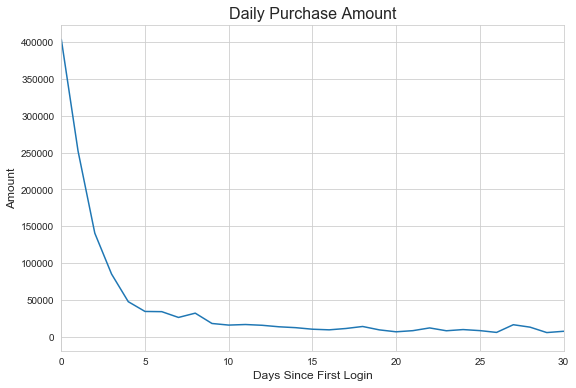

In [9]:
# daily purchase, spend, cumulative revenue

f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], tmp['rev'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Daily Purchase Amount', fontsize=16)

Text(0.5, 1.0, 'Daily Spend Amount')

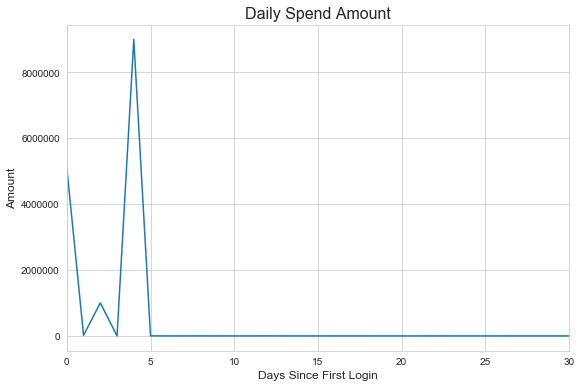

In [10]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], -tmp['amount'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Daily Spend Amount', fontsize=16)

Text(0.5, 1.0, 'Median Daily Purchase Amount')

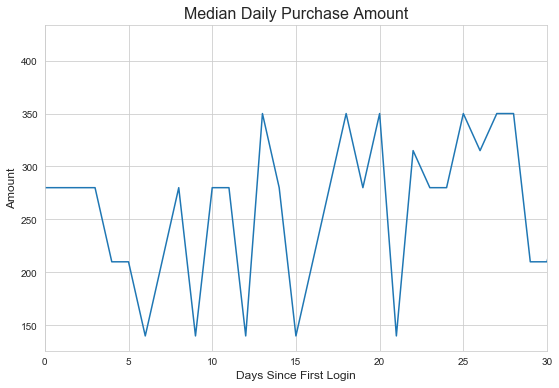

In [64]:
# daily median purchase, spend per user
tmp = ud.groupby('T').agg({
    'rev': 'median',
    'amount': 'median'
}).reset_index()

f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], tmp['rev'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Median Daily Purchase Amount', fontsize=16)

Text(0.5, 1.0, 'Median Daily Spend Amount')

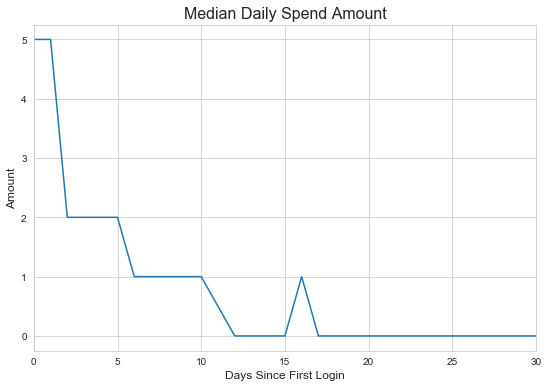

In [65]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], -tmp['amount'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Median Daily Spend Amount', fontsize=16)

Text(0.5, 1.0, 'Average Daily Purchase Amount')

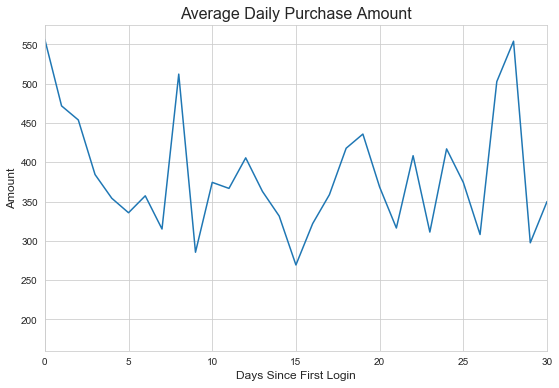

In [12]:
# daily average purchase, spend per user
tmp = ud.groupby('T').agg({
    'rev': 'mean',
    'amount': 'mean'
}).reset_index()

f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], tmp['rev'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Average Daily Purchase Amount', fontsize=16)

Text(0.5, 1.0, 'Average Daily Spend Amount')

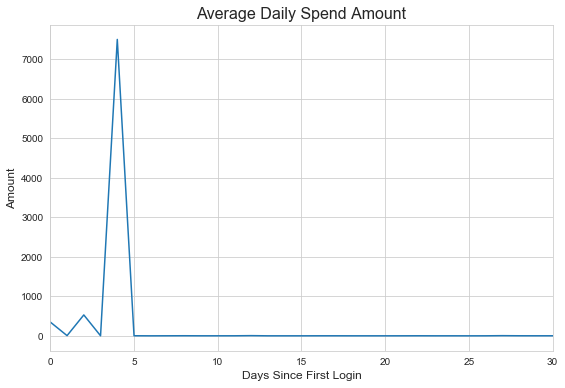

In [21]:
f, ax= plt.subplots(figsize=(9,6))
ax = sns.lineplot(tmp['T'], -tmp['amount'])
ax.set_xlabel('Days Since First Login', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.set_xlim(0, 30)
ax.set_title('Average Daily Spend Amount', fontsize=16)

In [29]:
spend_event_day0 = spend[spend['T']==0].groupby(['story', 'chapter']).agg({
    'amount': 'sum',
    'udid': 'nunique'
}).reset_index()
spend_event_day0['avg_spend_per_chapter'] = spend_event_day0['amount']/spend_event_day0['udid']


In [31]:
spend_event_day0.sort_values(by=['udid', 'avg_spend_per_chapter'], ascending=[False, True], inplace=True)


In [33]:
spend_event_day0[:10]

,story,chapter,amount,udid,avg_spend_per_chapter
24,Mean_Girls_Version_D,0,-77258,14252,-5.420853
3,Demi_Master,0,-2017995,3217,-627.290954
0,Demi_M_Closet,0,-998268,827,-1207.095526
4,Demi_Master,2,-1000724,604,-1656.827815
5,Demi_Master,3,-1000385,362,-2763.494475
25,Mean_Girls_Version_D,2,-5847,261,-22.402299
26,Mean_Girls_Version_D,3,-1965,247,-7.955466
27,Mean_Girls_Version_D,4,67,174,0.385057
28,Mean_Girls_Version_D,5,624,159,3.924528
31,Mean_Girls_Version_D,8,-433,99,-4.373737


In [23]:
spend_event_day4 = spend[spend['T']==4].groupby(['story', 'chapter']).agg({
    'amount': 'sum',
    'udid': 'nunique'
}).reset_index()
spend_event_day4['avg_spend_per_chapter'] = spend_event_day4['amount']/spend_event_day4['udid']
spend_event_day4.sort_values(by=['avg_spend_per_chapter'], ascending=True, inplace=True)


In [28]:
spend_event_day4[:10]

,story,chapter,amount,udid,avg_spend_per_chapter
22,Demi_Master,14,-1000100,132,-7576.515152
21,Demi_Master,13,-999825,140,-7141.607143
20,Demi_Master,12,-1000357,153,-6538.281046
0,Demi_M_Closet,0,-3999409,617,-6482.024311
17,Demi_Master,8,-1000319,159,-6291.314465
18,Demi_Master,10,-1000471,170,-5885.123529
41,Mean_Girls_Version_D,6,-242,4,-60.500000
60,My_Brothers_Best_Friend_Ld,6,-48,1,-48.000000
55,My_Brothers_Best_Friend_Ld,0,-48,1,-48.000000
63,Swiping_Right,4,-48,1,-48.000000


### EDA: User Retention

In [76]:
# 15-day user retention
mask = (session_purchase_daily['first_session_date'] >= datetime.strptime('2016-03-01', '%Y-%m-%d')) & (session_purchase_daily['first_session_date'] <= datetime.strptime('2016-03-07', '%Y-%m-%d')) & (session_purchase_daily['T']<=14)

cohorts = session_purchase_daily[mask].groupby(['first_session_date', 'T']).agg({
    'udid':'count',
    'session_num': 'sum',
    'rev': 'sum'
}).reset_index()

cohorts.rename(columns={'first_session_date': 'cohort_group', 
                       'udid': 'total_users', 
                       'session_num': 'total_sessions', 
                       'rev': 'total_revenue'}, inplace=True)

cohorts.set_index(['cohort_group', 'T'], inplace=True)
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.columns = user_retention.columns.astype(str)

In [77]:
user_retention

cohort_group,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07
T,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.477007,0.466307,0.464490,0.489701,0.486427,0.463870,0.465950
2,0.345284,0.358876,0.346939,0.349502,0.330342,0.353833,0.349104
3,0.282151,0.308818,0.282857,0.264120,0.272767,0.298924,0.287814
4,0.249415,0.267616,0.238776,0.235880,0.233363,0.255875,0.249462
5,0.225253,0.213708,0.200408,0.202658,0.198555,0.228421,0.217563
6,0.189010,0.192915,0.182449,0.161794,0.195053,0.215902,0.197849
7,0.162510,0.172507,0.173061,0.172425,0.192863,0.195256,0.171685
8,0.144193,0.157489,0.152245,0.161130,0.172504,0.152647,0.140502


Text(0.5, 1, '15-Day User Retention')

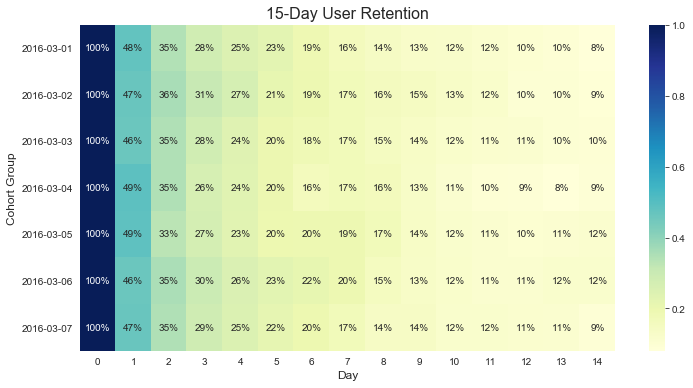

In [80]:
f, ax= plt.subplots(figsize=(12,6))
ax = sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), cmap='YlGnBu',
            annot=True, fmt='.0%')
ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Cohort Group', fontsize=12)
ax.set_title('15-Day User Retention', fontsize=16)


## Conversion Prediction

In [7]:
sessions = pd.merge(sessions, users[['udid', 'first_session_date']], how='left')
purchase = pd.merge(purchase, users[['udid', 'first_session_date']], how='left')
spend = pd.merge(spend, users[['udid', 'first_session_date']], how='left')

sessions['T'] = (sessions['date']-sessions['first_session_date']).map(lambda x: x.days)
purchase['T'] = (purchase['date']-purchase['first_session_date']).map(lambda x: x.days)
spend['T'] = (spend['date']-spend['first_session_date']).map(lambda x: x.days)

In [11]:
cat_cols = ['country', 'lang', 'device']
num_cols = ['session_count', 'active_days', 'days_since_last_session', 
       'purchase_amount', 'purchase_count', 'days_since_last_purchase',
       'spend_amount', 'spend_count', 'chapter_count', 'days_since_last_spend']
num_cols2 = num_cols + ['avg_session_count', 'median_session_count', 'avg_days_between_sessions', 'median_days_between_sessions']


### 1-Day Model

In [12]:
NFOLDS = 5
SEED = 26

In [17]:
# start: T = 0
# perf window: 1 day
# obs window: 1 day
train11 = generate_train_df(0, 1, 1)
train11 = revise_cat_cols(train11, 
                    country_list=['US', 'CA', 'GB', 'AU'], 
                    lang_list=['en'])
na_num_cols, na_cat_cols = report_na(train11[cat_cols+num_cols+['future_purchase_amount', 'future_purchase_count', 'converted']], show=False)
train11[na_num_cols] = train11[na_num_cols].fillna(0)
train11, cat_cols_oh = onehot_encode(train11)


In [26]:
print(train11.shape)
print(train11['converted'].value_counts())
print(sum(train11['converted'])/len(train11))
print(train11['user_type'].value_counts())

(22576, 38)
0.0    22041
1.0      535
Name: converted, dtype: int64
0.023697732104890148
3    11891
2    10150
1      535
Name: user_type, dtype: int64


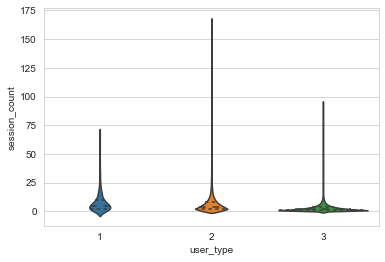

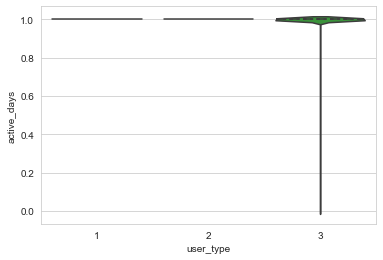

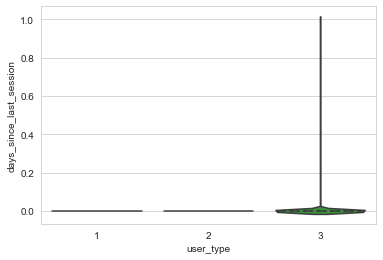

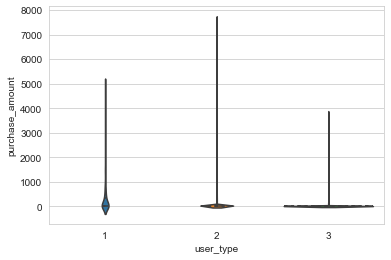

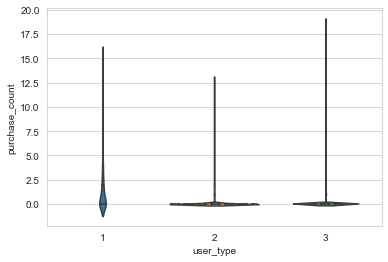

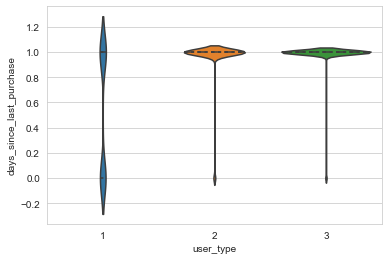

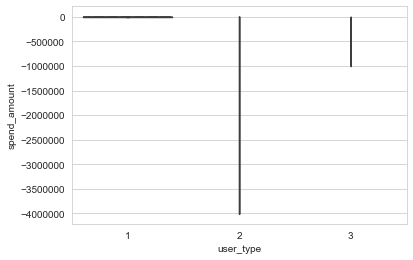

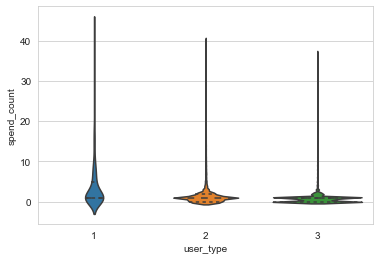

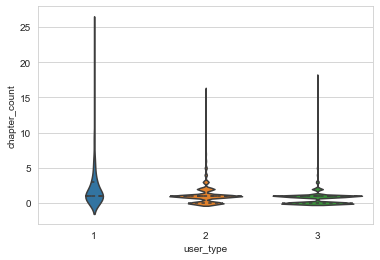

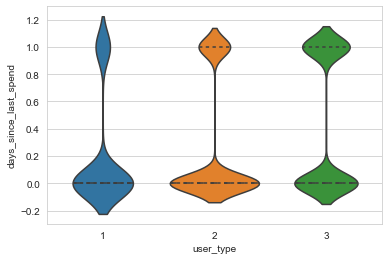

In [35]:
plot_cols = ['user_type']+num_cols
for col in plot_cols[1:]:
    ax = sns.violinplot(x="user_type", y=col, scale='area',
                    data=train11, inner="quartile")
    plt.show()

In [84]:
x_train_full, x_test_full, y_train, y_test = train_test_split(train11, train11['converted'], 
                                                    test_size=1/6, stratify=train11['converted'], random_state=SEED)

x_train, x_test = x_train_full[cat_cols_oh+num_cols], x_test_full[cat_cols_oh+num_cols]


In [47]:
lgb_params3 = {'n_estimators': 2998,
  'colsample_bytree': 0.5996490459119035,
  'learning_rate': 0.01,
  'subsample': 1,
  'max_depth': 3,
  'reg_alpha': 0.9975987713839573,
  'reg_lambda': 0.0007498916534665057,
  'gamma': 0
}

Fold 0
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.807775
[200]	valid_0's auc: 0.811865
[300]	valid_0's auc: 0.812654
[400]	valid_0's auc: 0.811605
[500]	valid_0's auc: 0.813685
[600]	valid_0's auc: 0.810233
[700]	valid_0's auc: 0.811995
[800]	valid_0's auc: 0.811957
Early stopping, best iteration is:
[480]	valid_0's auc: 0.814042
Fold 1
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.822315
[200]	valid_0's auc: 0.82252
[300]	valid_0's auc: 0.822821
[400]	valid_0's auc: 0.822399
Early stopping, best iteration is:
[24]	valid_0's auc: 0.825817
Fold 2
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.775456
[200]	valid_0's auc: 0.776342
[300]	valid_0's auc: 0.780882
[400]	valid_0's auc: 0.782217
[500]	valid_0's auc: 0.779845
[600]	valid_0's auc: 0.779097
[700]	valid_0's auc: 0.777714
[800]	valid_0's auc: 0.779219
Early stopping, best iteration is:
[438]	valid_0's auc: 0.7831

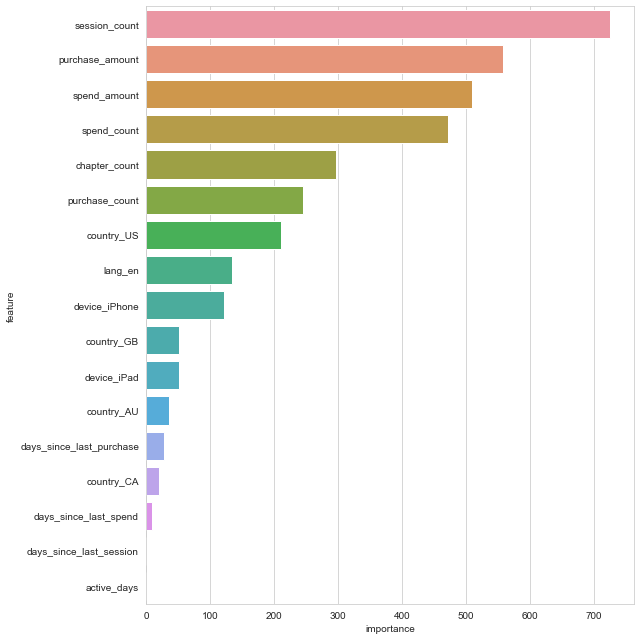

mean auc score:  0.8025867626521646


In [86]:
# 1-day lgb
lgb3 = lgb.LGBMClassifier(**lgb_params3, num_boost_rounds=2000)
train_pred, test_pred = get_oof_lgb(lgb3, x_train, y_train, x_test, display=True)


In [88]:
show_cv_score(y_train, train_pred, y_test, test_pred)


CV result
auc:  0.7693730664837819
cutoff:  [0.021758585773259922]
confusion matrix: [[tn, fp], [fn, tp]]
 [[12760  5607]
 [  137   309]]
Test result
auc:  0.7838179616252683
cutoff:  [0.01970714070528545]
confusion matrix: [[tn, fp], [fn, tp]]
 [[3102  572]
 [  36   53]]


Fold 0
auc:  0.8067700146183627
Fold 1
auc:  0.8186665484149169
Fold 2
auc:  0.7801933024775389
Fold 3
auc:  0.7562351444032831
Fold 4
auc:  0.8089413484981507
mean auc score:  0.7941612716824505


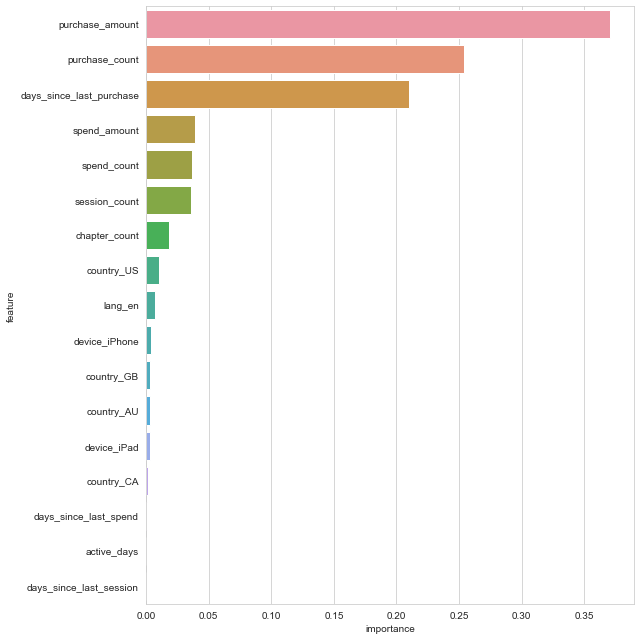

In [109]:
# 1-day rf
rf_params2 = {
    'n_estimators': 136, 
    'max_features': 8, 
    'max_depth': 4,
    'min_samples_split': 3,
    'min_samples_leaf': 1
}

rf2 = RandomForestClassifier(**rf_params2)
train_pred, test_pred = get_oof_rf(rf2, x_train, y_train, x_test)

In [90]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.7894108316216377
cutoff:  [0.016472320911870713]
confusion matrix: [[tn, fp], [fn, tp]]
 [[12860  5507]
 [  132   314]]
Test result
auc:  0.7976839987033084
cutoff:  [0.01672902839310081]
confusion matrix: [[tn, fp], [fn, tp]]
 [[2536 1138]
 [  26   63]]


In [93]:
# 1-day nn
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [94]:
train_pred, test_pred = get_oof_nn([10,6], x_train_scaled, y_train, x_test_scaled, 
               epochs=500, patience=100, class_weight=None)


Fold 0
fold auc:  0.7986305224076872
Fold 1
fold auc:  0.7964377679778339
Fold 2
fold auc:  0.7815878633874822
Fold 3
fold auc:  0.7565792895009743
Fold 4
fold auc:  0.7967693187762506
mean auc score:  0.7860009524100456


In [95]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.7768665824674347
cutoff:  [0.020167483016848564]
confusion matrix: [[tn, fp], [fn, tp]]
 [[12615  5752]
 [  141   305]]
Test result
auc:  0.8004272354168068
cutoff:  [0.021250110864639283]
confusion matrix: [[tn, fp], [fn, tp]]
 [[2528 1146]
 [  26   63]]


### 2-Day Model

In [51]:
# start: T = 0
# perf window: 2 day
# obs window: 1 day
train21 = generate_train_df(0, 2, 1)
train21 = revise_cat_cols(train21, 
                    country_list=['US', 'CA', 'GB', 'AU'], 
                    lang_list=['en'])

na_num_cols, na_cat_cols = report_na(train21[cat_cols+num_cols+['future_purchase_amount', 'future_purchase_count', 'converted']], show=False)
train21[na_num_cols] = train21[na_num_cols].fillna(0)
train21, cat_cols_oh = onehot_encode(train21)
train21 = train21[train21['active_days']>=1]

train21['user_type'] = np.where(train21['converted']==1, 1,
                                   np.where(train21['alive']==1, 2, 3))

In [52]:
print(train21.shape)
print(train21['converted'].value_counts())
print(sum(train21['converted'])/len(train21))
print(train21['user_type'].value_counts())

(22544, 38)
0.0    22234
1.0      310
Name: converted, dtype: int64
0.013750887154009937
3    14729
2     7505
1      310
Name: user_type, dtype: int64


In [42]:
x_train_full, x_test_full, y_train, y_test = train_test_split(train21, train21['converted'], 
                                                    test_size=1/6, stratify= train21['converted'], random_state=SEED)

x_train, x_test = x_train_full[cat_cols_oh+num_cols], x_test_full[cat_cols_oh+num_cols]


Fold 0
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.862817
[200]	valid_0's auc: 0.864765
[300]	valid_0's auc: 0.865741
[400]	valid_0's auc: 0.861402
[500]	valid_0's auc: 0.860377
[600]	valid_0's auc: 0.859203
Early stopping, best iteration is:
[275]	valid_0's auc: 0.866754
Fold 1
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.846593
[200]	valid_0's auc: 0.845675
[300]	valid_0's auc: 0.851921
[400]	valid_0's auc: 0.853357
[500]	valid_0's auc: 0.852371
[600]	valid_0's auc: 0.85245
[700]	valid_0's auc: 0.852825
Early stopping, best iteration is:
[387]	valid_0's auc: 0.853677
Fold 2
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.826348
[200]	valid_0's auc: 0.832458
[300]	valid_0's auc: 0.837922
[400]	valid_0's auc: 0.838462
[500]	valid_0's auc: 0.839594
[600]	valid_0's auc: 0.840412
[700]	valid_0's auc: 0.840004
[800]	valid_0's auc: 0.838819
[900]	valid_0's auc: 0.839285
E

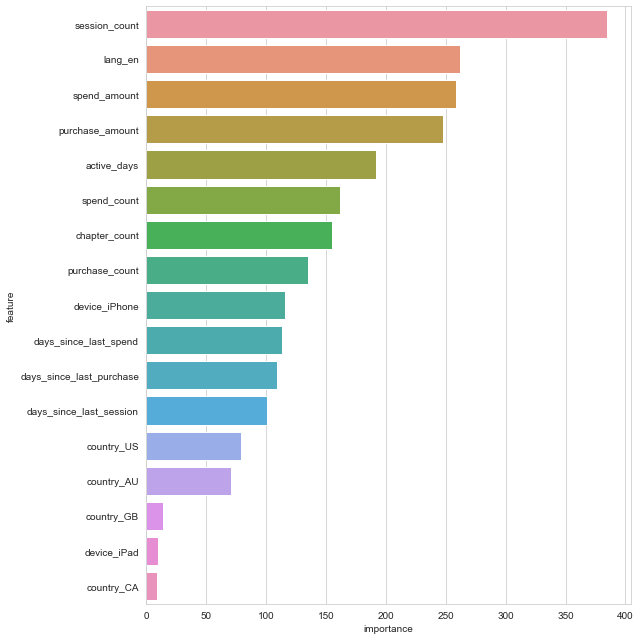

mean auc score:  0.8554469918681684


In [53]:
lgb6 = lgb.LGBMClassifier(**lgb_params3, num_boost_rounds=2000)
train_pred, test_pred = get_oof_lgb(lgb6, x_train, y_train, x_test, display=True)


In [155]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.8821343937020525
cutoff:  [0.012130319318221167]
confusion matrix: [[tn, fp], [fn, tp]]
 [[14904  3624]
 [   50   208]]
Test OOF result
auc:  0.9240187429947277
cutoff:  [0.012987905880535638]
confusion matrix: [[tn, fp], [fn, tp]]
 [[3021  685]
 [   6   46]]


Fold 0
auc:  0.8664926189174412
Fold 1
auc:  0.8458326497128795
Fold 2
auc:  0.835620727372163
Fold 3
auc:  0.8484632212195788
Fold 4
auc:  0.8614096253759912
mean auc score:  0.8515637685196108


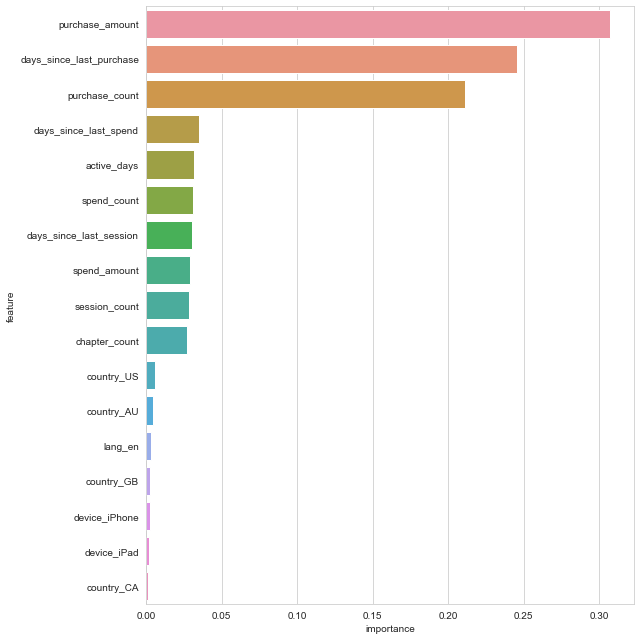

In [49]:
# 2-day rf
rf_params2 = {
    'n_estimators': 136, 
    'max_features': 8, 
    'max_depth': 4,
    'min_samples_split': 3,
    'min_samples_leaf': 1
}

rf4 = RandomForestClassifier(**rf_params2)
train_pred, test_pred = get_oof_rf(rf4, x_train, y_train, x_test)

In [159]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.8828949229157461
cutoff:  [0.009334159322975988]
confusion matrix: [[tn, fp], [fn, tp]]
 [[14751  3777]
 [   53   205]]
Test OOF result
auc:  0.9183782016688115
cutoff:  [0.00956357536631513]
confusion matrix: [[tn, fp], [fn, tp]]
 [[2957  749]
 [   7   45]]


In [176]:
# 2-day nn
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

train_pred_nn2, test_pred_nn2 = get_oof_nn([10,6], x_train_scaled, y_train, x_test_scaled, 
               epochs=500, patience=100, class_weight=None)

Fold 0
fold auc:  0.8855312590809084
Fold 1
fold auc:  0.8881834439118335
Fold 2
fold auc:  0.9041194459435149
Fold 3
fold auc:  0.8470466106093636
Fold 4
fold auc:  0.8655559015882903
mean auc score:  0.8780873322267823


In [177]:
show_cv_score(y_train, train_pred_nn2, y_test, test_pred_nn2)

CV result
auc:  0.8767165513582628
cutoff:  [0.011016646400094032]
confusion matrix: [[tn, fp], [fn, tp]]
 [[14730  3798]
 [   53   205]]
Test OOF result
auc:  0.904795757399643
cutoff:  [0.013800132274627685]
confusion matrix: [[tn, fp], [fn, tp]]
 [[2897  809]
 [   9   43]]


### 3-Day Model

In [83]:
train3 = pd.DataFrame()
for start in [0,1,2,3]:
    o = generate_train_df(start, 3, 1, True)
    train3 = pd.concat([train3, o], axis=0, ignore_index=True)
train3 = revise_cat_cols(train3, 
                    country_list=['US', 'CA', 'GB', 'AU'], 
                    lang_list=['en'])
na_num_cols, na_cat_cols = report_na(train3[cat_cols+num_cols2+['future_purchase_amount', 'future_purchase_count', 'converted']], show=True)
train3[na_num_cols] = train3[na_num_cols].fillna(0)
train3, cat_cols_oh = onehot_encode(train3)
mask = (train3['days_since_last_session']<=2) & (train3['active_days']>=1)
train3 = train3[mask]

In [92]:
sum(train3['converted'])

556.0

In [101]:
len(train3)

52975

In [98]:
sum(train3['converted'])/len(train3)

0.010061349693251533

In [178]:
x_train_full, x_test_full, y_train, y_test = train_test_split(train3, train3['converted'], 
                                                    test_size=1/6, stratify=train3['converted'], random_state=SEED)

x_train, x_test = x_train_full[cat_cols_oh+num_cols2], x_test_full[cat_cols_oh+num_cols2]


Fold 0
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.885973
[200]	valid_0's auc: 0.89152
[300]	valid_0's auc: 0.897615
[400]	valid_0's auc: 0.901213
[500]	valid_0's auc: 0.904907
[600]	valid_0's auc: 0.906384
[700]	valid_0's auc: 0.908205
[800]	valid_0's auc: 0.909424
[900]	valid_0's auc: 0.910651
[1000]	valid_0's auc: 0.911369
[1100]	valid_0's auc: 0.911484
[1200]	valid_0's auc: 0.911417
[1300]	valid_0's auc: 0.911006
[1400]	valid_0's auc: 0.911573
[1500]	valid_0's auc: 0.9114
Did not meet early stopping. Best iteration is:
[1378]	valid_0's auc: 0.911657
Fold 1
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.878108
[200]	valid_0's auc: 0.875953
[300]	valid_0's auc: 0.878661
[400]	valid_0's auc: 0.876337
Early stopping, best iteration is:
[22]	valid_0's auc: 0.881513
Fold 2
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.869088
[200]	valid_0's auc: 0.873588
[300]	valid_0'

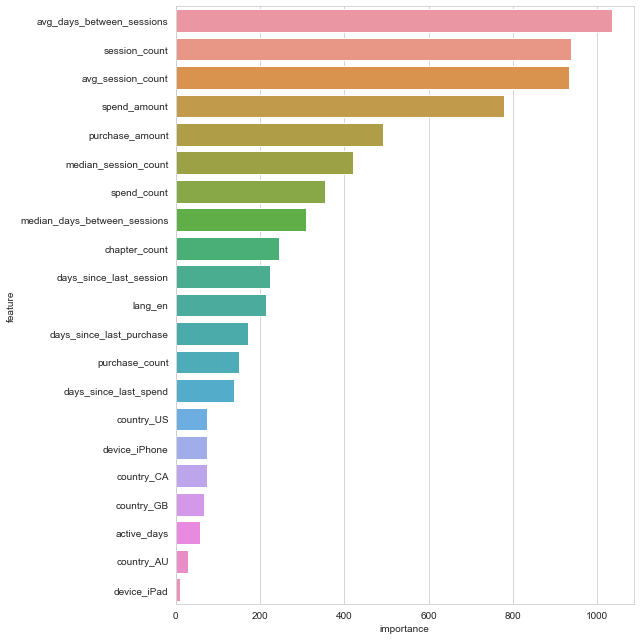

mean auc score:  0.8944259013100238


In [161]:
# 3-day lgb
lgb_params4 = {'n_estimators': 1500, 
  'colsample_bytree': 0.5768778652033217, 
  'learning_rate': 0.01,
  'subsample': 1,
  'max_depth': 3, 
  'reg_alpha': 0.9975987713839573,
  'reg_lambda': 0.0007498916534665057,
  'gamma': 0
}

lgb7 = lgb.LGBMClassifier(**lgb_params4, num_boost_rounds=2000)
train_pred, test_pred = get_oof_lgb(lgb7, x_train, y_train, x_test, display=True)

In [162]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.87864230331794
cutoff:  [0.008972830736000756]
confusion matrix: [[tn, fp], [fn, tp]]
 [[34877  8824]
 [   89   355]]
Test OOF result
auc:  0.883663324973745
cutoff:  [0.007832175595603896]
confusion matrix: [[tn, fp], [fn, tp]]
 [[7520 1221]
 [  20   69]]


Fold 0
auc:  0.8844109785649656
Fold 1
auc:  0.8700010284627053
Fold 2
auc:  0.8696481371969248
Fold 3
auc:  0.8590144756125782
Fold 4
auc:  0.8932243591391767
mean auc score:  0.8752597957952701


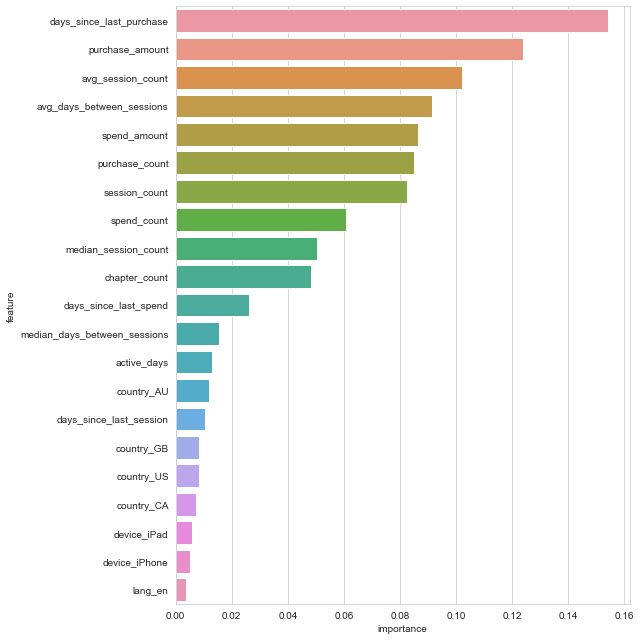

In [163]:
# 3-day rf
rf_params3 = {
    'n_estimators': 109, 
    'max_features': 11, 
    'max_depth': 8,
    'min_samples_split': 3,
    'min_samples_leaf': 1
}

rf4 = RandomForestClassifier(**rf_params3)
train_pred, test_pred = get_oof_rf(rf4, x_train, y_train, x_test)

In [164]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.8743173048795345
cutoff:  [0.005751416502009711]
confusion matrix: [[tn, fp], [fn, tp]]
 [[34056  9645]
 [   98   346]]
Test OOF result
auc:  0.8769405192371222
cutoff:  [0.005918776184661409]
confusion matrix: [[tn, fp], [fn, tp]]
 [[6793 1948]
 [  19   70]]


In [181]:
# 3-day nn
x_train[['avg_session_count', 'median_session_count']] = x_train[['avg_session_count', 'median_session_count']].fillna(0)
x_test[['avg_session_count', 'median_session_count']] = x_test[['avg_session_count', 'median_session_count']].fillna(0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

train_pred, test_pred = get_oof_nn([15,7], x_train_scaled, y_train, x_test_scaled, 
               epochs=500, patience=100, class_weight=None)



Fold 0
fold auc:  0.8678016869299332
Fold 1
fold auc:  0.8862365978453707
Fold 2
fold auc:  0.878186306019078
Fold 3
fold auc:  0.8581801352428458
Fold 4
fold auc:  0.8974237009230452
mean auc score:  0.8775656853920545


In [182]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.8738374108989199
cutoff:  [0.006464524660259485]
confusion matrix: [[tn, fp], [fn, tp]]
 [[34352  9349]
 [   95   349]]
Test OOF result
auc:  0.854278365291298
cutoff:  [0.006508612167090177]
confusion matrix: [[tn, fp], [fn, tp]]
 [[6672 2069]
 [  21   68]]


### 7-Day Model

In [54]:
train7 = generate_train_df(0, 7, None, True)
train7 = revise_cat_cols(train7, 
                    country_list=['US', 'CA', 'GB', 'AU'], 
                    lang_list=['en'])

na_num_cols, na_cat_cols = report_na(train7[cat_cols+num_cols+['future_purchase_amount', 'future_purchase_count', 'converted']], show=False)
train7[na_num_cols] = train7[na_num_cols].fillna(0)
train7, cat_cols_oh = onehot_encode(train7)

In [55]:
sum(train7['converted'])/len(train7)

0.023697732104890148

In [109]:
x_train_full, x_test_full, y_train, y_test = train_test_split(train7, train7['converted'], 
                                                    test_size=1/6, stratify=train7['converted'], random_state=SEED)

x_train, x_test = x_train_full[cat_cols_oh+num_cols2], x_test_full[cat_cols_oh+num_cols2]


Fold 0
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.897104
[200]	valid_0's auc: 0.907935
[300]	valid_0's auc: 0.910609
[400]	valid_0's auc: 0.910109
[500]	valid_0's auc: 0.910859
[600]	valid_0's auc: 0.911323
[700]	valid_0's auc: 0.911189
[800]	valid_0's auc: 0.910531
[900]	valid_0's auc: 0.910541
Early stopping, best iteration is:
[573]	valid_0's auc: 0.911444
Fold 1
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's auc: 0.892225
[200]	valid_0's auc: 0.901574
[300]	valid_0's auc: 0.907939
[400]	valid_0's auc: 0.913244
[500]	valid_0's auc: 0.913535
[600]	valid_0's auc: 0.913923
[700]	valid_0's auc: 0.915054
[800]	valid_0's auc: 0.915308
[900]	valid_0's auc: 0.916183
[1000]	valid_0's auc: 0.916366
[1100]	valid_0's auc: 0.917055
[1200]	valid_0's auc: 0.91751
[1300]	valid_0's auc: 0.917844
[1400]	valid_0's auc: 0.918149
[1500]	valid_0's auc: 0.91836
Did not meet early stopping. Best iteration is:
[1470]	valid_0's auc: 0

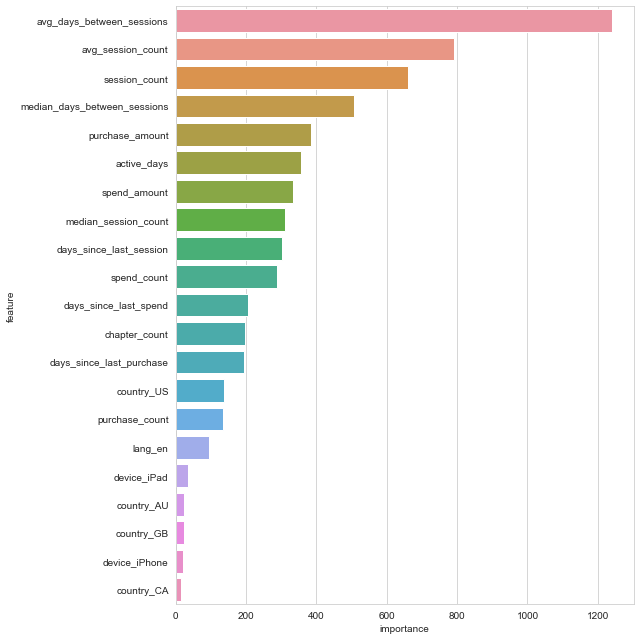

mean auc score:  0.9250301260876791


In [128]:
# 7-day lgb
lgb_params4 = {'n_estimators': 1500, 
  'colsample_bytree': 0.5768778652033217, 
  'learning_rate': 0.01,
  'subsample': 1,
  'max_depth': 3, 
  'reg_alpha': 0.9975987713839573,
  'reg_lambda': 0.0007498916534665057,
  'gamma': 0
}

lgb5 = lgb.LGBMClassifier(**lgb_params4, num_boost_rounds=2000)
train_pred, test_pred = get_oof_lgb(lgb5, x_train, y_train, x_test, display=True)

In [129]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.9239824617215366
cutoff:  [0.0272566224074436]
confusion matrix: [[tn, fp], [fn, tp]]
 [[15309  3058]
 [   74   372]]
Test OOF result
auc:  0.9330613543087471
cutoff:  [0.027751408493706397]
confusion matrix: [[tn, fp], [fn, tp]]
 [[3086  588]
 [  14   75]]


Fold 0
auc:  0.9019106231059819
Fold 1
auc:  0.8956250066135467
Fold 2
auc:  0.8993920827910225
Fold 3
auc:  0.868260147409945
Fold 4
auc:  0.8633369666770476
mean auc score:  0.8857049653195087


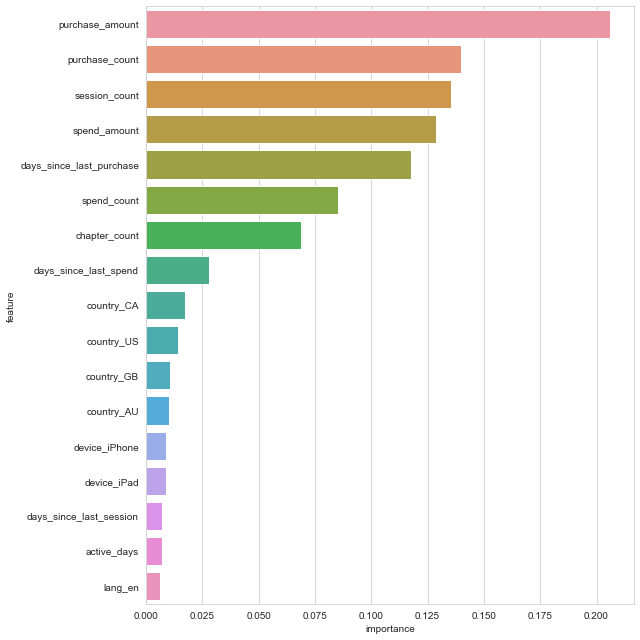

In [156]:
# 7-day rf
rf_params3 = {
    'n_estimators': 109, 
    'max_features': 11, 
    'max_depth': 8,
    'min_samples_split': 3,
    'min_samples_leaf': 1
}

rf3 = RandomForestClassifier(**rf_params3)
train_pred, test_pred = get_oof_rf(rf3, x_train, y_train, x_test)


In [157]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.8820934960370058
cutoff:  [0.01095453459572056]
confusion matrix: [[tn, fp], [fn, tp]]
 [[14936  3592]
 [   50   208]]
Test OOF result
auc:  0.904728299223712
cutoff:  [0.010929112544616862]
confusion matrix: [[tn, fp], [fn, tp]]
 [[2995  711]
 [  10   42]]


In [135]:
# 7-day nn
x_train[['avg_session_count', 'median_session_count']] = x_train[['avg_session_count', 'median_session_count']].fillna(0)
x_test[['avg_session_count', 'median_session_count']] = x_test[['avg_session_count', 'median_session_count']].fillna(0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

train_pred, test_pred = get_oof_nn([15,7], x_train_scaled, y_train, x_test_scaled, 
               epochs=500, patience=100, class_weight=None)



Fold 0
fold auc:  0.8789153052424263
Fold 1
fold auc:  0.8644284464778309
Fold 2
fold auc:  0.8574220286172369
Fold 3
fold auc:  0.8881757862568331
Fold 4
fold auc:  0.8979923339767572
mean auc score:  0.8773867801142169


In [136]:
show_cv_score(y_train, train_pred, y_test, test_pred)

CV result
auc:  0.8740360038390163
cutoff:  [0.024351319298148155]
confusion matrix: [[tn, fp], [fn, tp]]
 [[14572  3795]
 [   92   354]]
Test OOF result
auc:  0.8980048075452771
cutoff:  [0.026196525245904923]
confusion matrix: [[tn, fp], [fn, tp]]
 [[2924  750]
 [  16   73]]


# Appendix

#### helper functions

In [27]:
import re
# generate train df with x-day performance window, y-day observation window
def generate_train_df(start, x, y=None, compute_session_dist=False,
                      users=users, sessions=sessions, purchase=purchase, spend=spend):
    # x: performance window
    # start: from day T
    # y: observation window
    
    end = start + x
    
    def split_df(df, start, end, y):
        if y is not None:
            return df[(df['T']>=start) & (df['T']<end)], df[(df['T'] >= end) & (df['T']<end+y)]
        else:
            return df[(df['T']>=start) & (df['T']<end)], df[(df['T'] >= end)]

    sessions1, sessions2 = split_df(sessions, start, end, y)
    purchase1, purchase2 = split_df(purchase, start, end, y)
    spend1, spend2 = split_df(spend, start, end, y)


    o1 = purchase2.groupby('udid').agg(
        {'rev':'sum', 'ts': 'count'}).reset_index()
    o1.rename(columns={'rev': 'future_purchase_amount', 'ts': 'future_purchase_count'}, inplace=True)
    o1['converted'] = np.where(o1['future_purchase_amount']>0, 1, 0)
    
    o2 = sessions2.groupby('udid').agg(
        {'ts': 'count'}).reset_index()
    o2.rename(columns={'ts': 'future_session_count'}, inplace=True)
    o2['alive'] = np.where(o2['future_session_count']>0, 1, 0)
    

    p1 = sessions1.groupby('udid').agg({
        'ts': 'count',
        'date': 'nunique',
        'T': 'max'
    }).reset_index()
    p1.rename(columns={'ts':'session_count', 'date': 'active_days', 'T': 'last_session_time'}, inplace=True)

    p2 = purchase1.groupby('udid').agg({
        'rev': 'sum',
        'ts': 'count',
        'T': 'max'
    }).reset_index()
    p2.rename(columns={'rev':'purchase_amount', 'ts': 'purchase_count', 'T': 'last_purchase_time'}, inplace=True)

    spend1['story_chapter'] = spend['story']+'_'+spend['chapter'].astype(str)
    p3 = spend1.groupby('udid').agg({
        'amount': 'sum',
        'ts': 'count',
        'T': 'max',
        'story_chapter': 'nunique'
    }).reset_index()
    p3.rename(columns={'amount':'spend_amount', 'ts': 'spend_count', 
                       'T': 'last_spend_time', 'story_chapter': 'chapter_count'}, inplace=True)

    if 'first_session_date' not in users.columns:
        first_session = sessions.groupby(['udid'])['date'].min().reset_index()
        first_session.rename(columns={'date':'first_session_date'}, inplace=True)
        users = pd.merge(users, first_session)

    df = pd.merge(users[['udid', 'install_date', 'first_session_date', 'country', 'lang', 'hw_ver', 'os_ver']], p1, how='left')
    df = pd.merge(df, p2, how='left')
    df = pd.merge(df, p3, how='left')
    df = pd.merge(df, o1, how='left')
    df = pd.merge(df, o2, how='left')
    
    df['days_since_last_session'] = (end-1-df['last_session_time']).fillna(x)
    df['days_since_last_purchase'] = (end-1-df['last_purchase_time']).fillna(x)
    df['days_since_last_spend'] = (end-1-df['last_spend_time']).fillna(x)
    df['T_start'] = start
    df['T_end'] = end
    
    if x>1 and compute_session_dist:
        ud = sessions.groupby(['udid','T']).agg({
            'session_num':'count'}).reset_index()
        ud = pd.merge(ud, users[['udid', 'first_session_date']], how='left')
        ud.rename(columns={'session_num': 'session_count'}, inplace=True)
        ud['T_lag1'] = ud.groupby('udid')['T'].shift()
        ud['days_between_sessions'] = ud['T'] - ud['T_lag1']
        
        usd = pd.DataFrame()
        usd['session_count_dist'] = ud.groupby('udid')['session_count'].apply(list)
        usd['days_between_sessions'] = ud.groupby('udid')['days_between_sessions'].apply(list)
        usd['avg_session_count'] = usd['session_count_dist'].map(lambda x: np.mean(x))
        usd['median_session_count'] = usd['session_count_dist'].map(lambda x: np.median(x))
        usd['avg_days_between_sessions'] = usd['days_between_sessions'].map(lambda x: np.mean(x[1:]))
        usd['median_days_between_sessions'] = usd['days_between_sessions'].map(lambda x: np.median(x[1:]))
        usd = usd.reset_index()
        
        df = pd.merge(df, usd, how='left')
        to_fill0 = ['converted', 'alive']
        to_fillx = ['avg_days_between_sessions', 'median_days_between_sessions']
        df[to_fill0] = df[to_fill0].fillna(0)
        df[to_fillx]= df[to_fillx].fillna(x)
        
        # 1: payer; 2: non-payer, alive; 3: churned
        df['user_type'] = np.where(df['converted']==1, 1,
                                   np.where(df['alive']==1, 2, 3))
    
    return df


In [10]:
def report_na(df, show=True):
    num_cols, cat_cols = [], []
    for col in df.columns:
        na_count = df[col].isnull().sum()
        if na_count > 0:
            if df[col].dtype == 'float' or df[col].dtype == 'int':
                num_cols.append(col)
            else:
                cat_cols.append(col)
        if show:
            print(col, na_count)
    return num_cols, cat_cols

def revise_cat_cols(df, 
                    country_list=['US', 'CA', 'GB', 'AU'], 
                    lang_list=['en']):
    df.rename(columns={'country': 'country_original', 
                      'lang': 'lang_original'}, inplace=True)
    df['country'] = df['country_original'].map(lambda x: x if x in country_list else 'Other')
    df['lang'] = df['lang_original'].map(lambda x: x if x in lang_list else 'Other')
    df['device'] = df['hw_ver'].map(lambda x: re.sub('\d+$', '', x.split(',')[0]))
    return df


def onehot_encode(df, 
                  cat_cols=['country', 'lang', 'device'], 
                  to_drop=['country_Other', 'lang_Other', 'device_iPod']):
    cat_df, cat_cols_oh = pd.DataFrame(), []
    for cat_col in cat_cols:
        tmp = pd.get_dummies(df[cat_col], prefix=cat_col)
        cat_df = pd.concat([cat_df, tmp], axis=1)
    
    cat_df.drop(to_drop, axis=1, inplace=True)
    cat_cols_oh = cat_df.columns.tolist()
    df = pd.concat([df, cat_df], axis=1)
    
    return df, cat_cols_oh

from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

def compute_confusion_matrix(predicted, threshold, target):
    pred = np.where(predicted>=threshold, 1, 0)
    return confusion_matrix(target, pred)

def show_cv_score(y_train, train_pred, 
                  y_test, test_pred):
    print('CV result')
    print('auc: ', roc_auc_score(y_train, train_pred))
    threshold = find_optimal_cutoff(y_train, train_pred)
    print('cutoff: ', threshold)
    cv_cm = compute_confusion_matrix(train_pred, threshold[0], y_train)
    print('confusion matrix: [[tn, fp], [fn, tp]]\n', cv_cm)

    print('Test OOF result')
    print('auc: ', roc_auc_score(y_test, test_pred))
    threshold0 = find_optimal_cutoff(y_test, test_pred)
    print('cutoff: ', threshold0)
    test_cm = compute_confusion_matrix(test_pred, threshold[0], y_test)
    print('confusion matrix: [[tn, fp], [fn, tp]]\n', test_cm)

#### Model training and hyperparameter tuning functions

In [45]:
def get_oof_lgb(clf, x_train, y_train, x_test=None, display=True, return_score=False):
    skfolder = StratifiedKFold(NFOLDS, random_state=SEED, shuffle=True)
    skf = skfolder.split(x_train, y_train)
    
    ntrain = len(x_train)
    oof_train = np.zeros((ntrain,))
    if x_test is not None:
        ntest = len(x_test)
        oof_test = np.zeros((ntest,))
        oof_test_skf = np.empty((NFOLDS, ntest))
    
    auc = []
    
    features = x_train.columns.tolist()
    feature_importance_df = pd.DataFrame()

    for i, (train_index, val_index) in enumerate(skf):
        print('Fold %d'% i)
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_val = x_train.iloc[val_index]
        y_val = y_train.iloc[val_index]

        clf.fit(x_tr, y_tr, 
                eval_set=[(x_val, y_val)], 
                eval_metric='auc', 
                early_stopping_rounds=400, 
                verbose=100)
            
        if clf.best_iteration_ is None:
            oof_train[val_index] = clf.predict_proba(x_val)[:,1]
            if x_test is not None:
                oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]
        else: 
            oof_train[val_index] = clf.predict_proba(x_val, num_iteration=clf.best_iteration_)[:,1]
            if x_test is not None:
                oof_test_skf[i, :] = clf.predict_proba(x_test, num_iteration=clf.best_iteration_)[:,1]
        
        fold_auc = roc_auc_score(y_val, oof_train[val_index])
        auc.append(fold_auc)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0, ignore_index=True)
    
    if x_test is not None:    
        oof_test[:] = oof_test_skf.mean(axis=0)
    
    if display:
        display_importances(feature_importance_df)
        
    auc = np.mean(auc)
    print('mean auc score: ', auc)
    
    if return_score:
        return auc
    elif x_test is not None:
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    else:
        return oof_train.reshape(-1, 1)

    
def display_importances(df):
    best_features = df.groupby('feature').agg({'importance': 'mean'}).reset_index().sort_values(by='importance', ascending=False)
    #best_features = df.loc[df['feature'].isin(cols)]
    plt.figure(figsize=(9,9))
    sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
    plt.tight_layout()
    plt.show()

def get_best_fold_lgb(clf, x_train, y_train, best_fold, x_test=None):
    skfolder = StratifiedKFold(NFOLDS, random_state=SEED, shuffle=True)
    skf = skfolder.split(x_train, y_train)

    for i, (train_index, val_index) in enumerate(skf):
        if i == best_fold:
            print('Fold %d'% i)
            x_tr = x_train.iloc[train_index]
            y_tr = y_train.iloc[train_index]
            x_val = x_train.iloc[val_index]
            y_val = y_train.iloc[val_index]

            clf.fit(x_tr, y_tr, 
                eval_set=[(x_val, y_val)], 
                eval_metric='auc', 
                early_stopping_rounds=400, 
                verbose=100)
            
            if clf.best_iteration_ is None:
                train_pred = clf.predict_proba(x_train)[:,1]
                if x_test is not None:
                    test_pred = clf.predict_proba(x_test)[:,1]
            else: 
                train_pred = clf.predict_proba(x_train, num_iteration=clf.best_iteration_)[:,1]
                if x_test is not None:
                    test_pred = clf.predict_proba(x_test, num_iteration=clf.best_iteration_)[:,1]
            
            print('auc: ', roc_auc_score(y_train, train_pred))
    if x_test is not None:
        return clf, train_pred, test_pred
    else:
        return clf, train_pred

    
def lgb_evaluate(n_estimators,
                 colsample_bytree,
                 learning_rate, 
                 num_leaves, 
                 subsample, 
                 max_depth, 
                 reg_alpha, 
                 reg_lambda, 
                 gamma):
    warnings.simplefilter('ignore')
    params = {}
    params['n_estimators'] = int(n_estimators)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['learning_rate'] = max(learning_rate, 0)
    params['num_leaves'] = int(num_leaves)
    params['subsample'] = max(min(subsample, 1), 0)
    params['max_depth'] = int(max_depth)
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lambda'] = max(reg_lambda, 0)
    params['gamma'] = max(gamma, 0)
    clf = lgb.LGBMClassifier(**params, num_boost_rounds=2000)
    auc = get_oof_lgb(clf, x_train, y_train, x_test=None, display=False, return_score=True)
    
    return auc


def get_oof_rf(clf, x_train, y_train, x_test=None, display=True, return_score=False):
    skfolder = StratifiedKFold(NFOLDS, random_state=SEED, shuffle=True)
    skf = skfolder.split(x_train, y_train)
    
    ntrain = len(x_train)
    oof_train = np.zeros((ntrain,))
    if x_test is not None:
        ntest = len(x_test)
        oof_test = np.zeros((ntest,))
        oof_test_skf = np.empty((NFOLDS, ntest))
    
    auc = []
    features = x_train.columns.tolist()
    feature_importance_df = pd.DataFrame()
    
    for i, (train_index, val_index) in enumerate(skf):
        print('Fold %d'% i)
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_val = x_train.iloc[val_index]
        y_val = y_train.iloc[val_index]

        clf.fit(x_tr, y_tr)
        oof_train[val_index] = clf.predict_proba(x_val)[:,1]
        fold_auc = roc_auc_score(y_val, oof_train[val_index])
        auc.append(fold_auc)
        print('auc: ', fold_auc)
        if x_test is not None:
            oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0, ignore_index=True)
    
    auc = np.mean(auc)
    print('mean auc score: ', auc)       
    
    if display:
        display_importances(feature_importance_df)
    
    if return_score:
        return auc
    elif x_test is not None:    
        oof_test[:] = oof_test_skf.mean(axis=0)
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    else:
        return oof_train.reshape(-1, 1)

    
def rf_evaluate(n_estimators,  # default 100 
                max_features,  # n_features, sqrt(n_features)
                max_depth, 
                min_samples_split,  # default 2
                min_samples_leaf):  # default 1
                #bootstrap
               
    warnings.simplefilter('ignore')
    params = {}
    params['n_estimators'] = int(n_estimators)
    params['max_features'] = int(max_features)
    params['max_depth'] = int(max_depth)
    params['min_samples_split'] = int(min_samples_split)
    params['min_samples_leaf'] = int(min_samples_leaf)
    clf = RandomForestClassifier(**params)
    auc = get_oof_rf(clf, x_train, y_train, x_test=None, display=False, return_score=True)
    
    return auc


def init_nn_model(layers, input_dim):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=input_dim, activation='relu'))
    model.add(Dense(layers[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def get_oof_nn(layers, x_train, y_train, x_test=None, 
               epochs=500, patience=100, class_weight=None):
    skfolder = StratifiedKFold(NFOLDS, random_state=SEED, shuffle=True)
    skf = skfolder.split(x_train, y_train)
    
    ntrain = len(x_train)
    oof_train = np.zeros((ntrain,))
    if x_test is not None:
        ntest = len(x_test)
        oof_test = np.zeros((ntest,))
        oof_test_skf = np.empty((NFOLDS, ntest))
    auc = []

    for i, (train_index, val_index) in enumerate(skf):
        print('Fold %d'% i)
        x_tr = x_train[train_index, :]
        y_tr = y_train.iloc[train_index]
        x_val = x_train[val_index, :]
        y_val = y_train.iloc[val_index]

        clf = init_nn_model(layers=layers, input_dim=x_train.shape[1])
        clf.fit(x_tr, y_tr, 
                validation_data=(x_val, y_val), 
                epochs=epochs, 
                class_weight=class_weight,
                callbacks=[EarlyStopping(patience=patience)], verbose=0)
            
        train_pred = clf.predict_proba(x_val)
        oof_train[val_index] = train_pred.reshape(train_pred.shape[0],)
        fold_auc = roc_auc_score(y_val, oof_train[val_index])
        auc.append(fold_auc)
        print('fold auc: ', fold_auc)
        if x_test is not None:
            test_pred = clf.predict_proba(x_test)
            oof_test_skf[i, :] = test_pred.reshape(test_pred.shape[0],)
        
    if x_test is not None:
        oof_test[:] = oof_test_skf.mean(axis=0)
    auc = np.mean(auc)
    print('mean auc score: ', auc)

    if x_test is not None:
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    else:
        return oof_train.reshape(-1, 1)
    
    
def show_cv_result(gs):
    d = gs.cv_results_
    df = pd.DataFrame([d['params'], d['mean_test_score'], d['rank_test_score']], 
             index=['params', 'mean_test_score', 'rank_test_score']).T
    df.sort_values(by=['rank_test_score'], ascending=True, inplace=True)
    return df


# fit model on all train data
def fit_model(clf, x_train, y_train, x_test, y_test, print_score=True):
    clf.fit(x_train, y_train)
    train_pred = clf.predict_proba(x_train)[:,1]
    test_pred = clf.predict_proba(x_test)[:,1]
    
    if print_score:
        print('Train result')
        print('auc: ', roc_auc_score(y_train, train_pred))
        threshold = find_optimal_cutoff(y_train, train_pred)
        print('cutoff: ', threshold)
        train_cm = compute_confusion_matrix(train_pred, threshold[0], y_train)
        print('confusion matrix: [[tn, fp], [fn, tp]]\n', train_cm)

        print('Test result')
        print('auc: ', roc_auc_score(y_test, test_pred))
        threshold0 = find_optimal_cutoff(y_test, test_pred)
        print('cutoff: ', threshold0)
        test_cm = compute_confusion_matrix(test_pred, threshold[0], y_test)
        print('confusion matrix: [[tn, fp], [fn, tp]]\n', test_cm)
    
    return clf, train_pred, test_pred
